## Unit 4 Capstone

For this project, I will use a NTLK corpus which contains a collection of inaugural speeches given by presidents of the US from 1789 to 2009. I will be clustering these speeches into sentences in order to create features and classify the text using supervised and unsupervised techniques that I learned from Unit 4.

In [46]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import spacy
from nltk.corpus import stopwords, gutenberg, inaugural
from collections import Counter
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor                          
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC 
from sklearn.cluster import KMeans
%matplotlib inline

In [17]:
nltk.download('inaugural')
nltk.download('wordnet')
inaugural.fileids()

[nltk_data] Downloading package inaugural to
[nltk_data]     C:\Users\edgor\AppData\Roaming\nltk_data...
[nltk_data]   Package inaugural is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edgor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['1789-Washington.txt',
 '1793-Washington.txt',
 '1797-Adams.txt',
 '1801-Jefferson.txt',
 '1805-Jefferson.txt',
 '1809-Madison.txt',
 '1813-Madison.txt',
 '1817-Monroe.txt',
 '1821-Monroe.txt',
 '1825-Adams.txt',
 '1829-Jackson.txt',
 '1833-Jackson.txt',
 '1837-VanBuren.txt',
 '1841-Harrison.txt',
 '1845-Polk.txt',
 '1849-Taylor.txt',
 '1853-Pierce.txt',
 '1857-Buchanan.txt',
 '1861-Lincoln.txt',
 '1865-Lincoln.txt',
 '1869-Grant.txt',
 '1873-Grant.txt',
 '1877-Hayes.txt',
 '1881-Garfield.txt',
 '1885-Cleveland.txt',
 '1889-Harrison.txt',
 '1893-Cleveland.txt',
 '1897-McKinley.txt',
 '1901-McKinley.txt',
 '1905-Roosevelt.txt',
 '1909-Taft.txt',
 '1913-Wilson.txt',
 '1917-Wilson.txt',
 '1921-Harding.txt',
 '1925-Coolidge.txt',
 '1929-Hoover.txt',
 '1933-Roosevelt.txt',
 '1937-Roosevelt.txt',
 '1941-Roosevelt.txt',
 '1945-Roosevelt.txt',
 '1949-Truman.txt',
 '1953-Eisenhower.txt',
 '1957-Eisenhower.txt',
 '1961-Kennedy.txt',
 '1965-Johnson.txt',
 '1969-Nixon.txt',
 '1973-Nixon.txt',
 '1

## Text Processing

Here I will create a list to seprate the text files into sentences. I will also do some text cleaning and removes characters and any numeric values.

In [18]:
file_ids = inaugural.fileids()

labels =[]

for file in file_ids:
    
    president = re.sub("[^a-zA-Z]", '', file[5:-4])
    labels.append([file, president])
    
    
sent_list =[]
president_list = []

for i in range(len(labels)):
    sents = inaugural.sents(labels[i][0]) #get sentences from document
    joined_sents = [(' '.join(sent), labels[i][1]) for sent in sents]
    
    # write out to individual lists for easier text processing
    for i in range(len(joined_sents)): 
        sent_list.append(joined_sents[i][0]) 
        president_list.append(joined_sents[i][1])  

In [19]:
sent_list_clean = []


for sent in sent_list:
    sent = re.sub("[^a-zA-Z]", ' ', sent) 
    if sent == sent.upper():              
        sent = ""                         
    sent_list_clean.append(sent)
sent_list_clean[:4]

['Fellow   Citizens of the Senate and of the House of Representatives  ',
 'Among the vicissitudes incident to life no event could have filled me with greater anxieties than that of which the notification was transmitted by your order   and received on the   th day of the present month  ',
 'On the one hand   I was summoned by my Country   whose voice I can never hear but with veneration and love   from a retreat which I had chosen with the fondest predilection   and   in my flattering hopes   with an immutable decision   as the asylum of my declining years    a retreat which was rendered every day more necessary as well as more dear to me by the addition of habit to inclination   and of frequent interruptions in my health to the gradual waste committed on it by time  ',
 'On the other hand   the magnitude and difficulty of the trust to which the voice of my country called me   being sufficient to awaken in the wisest and most experienced of her citizens a distrustful scrutiny into his

In [20]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

lemma_sents = []

for sent in sent_list_clean:
    words = word_tokenize(sent)
    word_lemma = [lemmatizer.lemmatize(word) for word in words]
    sent_lemma = ' '.join(word_lemma)
    lemma_sents.append(sent_lemma)

In [51]:
#dataframe
df = pd.DataFrame()
df['sent'] = lemma_sents
df['president'] = president_list

df = df[df.sent!=""]
df.head()

,sent,president
0,Fellow Citizens of the Senate and of the House...,Washington
1,Among the vicissitude incident to life no even...,Washington
2,On the one hand I wa summoned by my Country wh...,Washington
3,On the other hand the magnitude and difficulty...,Washington
4,In this conflict of emotion all I dare aver is...,Washington


In [52]:
df.groupby('president').count()/df['sent'].count()

,sent
president,
Adams,0.022802
Buchanan,0.018283
Bush,0.069228
Carter,0.010887
Cleveland,0.020953
Clinton,0.039647
Coolidge,0.040468
Eisenhower,0.044166
Garfield,0.023007


## Unsupervised Features

To create the featues, I will be using TF-IDF and LSA.

In [22]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, stratify = df['president'], test_size = 0.25, random_state = 42)

print(df_train.shape)
print(df_test.shape)

(3651, 2)
(1217, 2)


## Term Frequency-Inverse Document Frequency (TF-IDF)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', #filter out stopwords
                             lowercase=True,       #convert all to lowercase
                             min_df=2,             #use words appearing at least twice in doc
                             max_df=0.5,           #drop words that occur in more than half of doc
                             use_idf=True,
                             smooth_idf=True,
                             norm='l2')

#data to vectorize
X_train = df_train['sent']
X_test = df_test['sent']

#vectorize training data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(3651, 3833)
(1217, 3833)


In [24]:
weights = np.asarray(X_train_tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'word':vectorizer.get_feature_names(), 'avg_weight': weights})
print('Train:\n',weights_df.sort_values(by = 'avg_weight', ascending =False).head(10))

weights = np.asarray(X_test_tfidf.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'avg_weight': weights})
print("\nTest:\n", weights_df.sort_values(by='avg_weight', ascending=False).head(10))

Train:
             word  avg_weight
1675          ha    0.021161
2490      people    0.019708
1633  government    0.019441
2302      nation    0.017204
3805       world    0.014010
821      country    0.012516
1650       great    0.012405
3128       shall    0.011734
3481        time    0.011678
2575       power    0.011608

Test:
             word  avg_weight
1675          ha    0.021173
1633  government    0.020462
2490      people    0.019677
2302      nation    0.018214
3805       world    0.014305
2055         law    0.013720
561      citizen    0.012848
2333         new    0.012820
173      america    0.012335
821      country    0.011552


## LSA using Singular Value Decomposition (SVD)

In [25]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Reduce number of features from 3833 to 300
svd = TruncatedSVD(300)

lsa_pipe = make_pipeline(svd, Normalizer())

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa_pipe.fit_transform(X_train_tfidf)
X_test_lsa = lsa_pipe.transform(X_test_tfidf)

# Examine variance captured in reduced feature space
variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by components:', total_variance*100)

sent_by_component = pd.DataFrame(X_train_lsa, index=X_train)

for i in range(5):
    print('Component {}:'.format(i))
    print(sent_by_component.loc[:, i].sort_values(ascending=False)[:5])

Percent variance captured by components: 41.96346350050322
Component 0:
sent
On this subject it might become me better to be silent or to speak with diffidence but a something may be expected the occasion I hope will be admitted a an apology if I venture to say that if a preference upon principle of a free republican government formed upon long and serious reflection after a diligent and impartial inquiry after truth if an attachment to the Constitution of the United States and a conscientious determination to support it until it shall be altered by the judgment and wish of the people expressed in the mode prescribed in it if a respectful attention to the constitution of the individual States and a constant caution and delicacy toward the State government if an equal and impartial regard to the right interest honor and happiness of all the States in the Union without preference or regard to a northern or southern an eastern or western position their various political opinion on unessen

Name: 0, dtype: float64
Component 1:
sent
The whole world is at peace                                                                                                                                                                                                                                                        0.527549
And so too is all the world                                                                                                                                                                                                                                                        0.511543
We have come to a new realization of our place in the world and a new appraisal of our Nation by the world                                                                                                                                                                         0.495419
Let u be proud that by our bold new initiative and by our steadfastness for peace with honor we have made 

## Non-negative Matrix Factorization (NMF)

In [28]:
#from sklearn.decomposition import NMF

#X_train_tfidf = vectorizer.fit_transform(X_train)
#X_test_tfidf = vectorizer.transform(X_test)

#nmf = NMF(n_components=10, random_state=42, alpha=.1, l1_ratio=.5, init='nndsvd').fit(X_train_tfidf)

## Supervised Learning

I use Random Forest and Logistic Regression on my sets of created features and compare them in order to determine which model performs better in predicting the president of the inaugural speech to which the sentence belongs to.

In [29]:
Y_train = df_train['president']
Y_test = df_test['president']

## Random Forest Classifier

In [34]:
#Random Forest Classifier to test TF-IDF features
rfc = RandomForestClassifier(n_estimators=100,
                             max_depth=3,
                             random_state=42,class_weight='balanced') 


X_train1 = X_train_tfidf
X_test1 = X_test_tfidf

    
rfc.fit(X_train1, Y_train)
Y_pred_tf = rfc.fit(X_train1, Y_train).predict(X_test1)
        
print('TF-IDF Features:')
print('Train accuracy:', rfc.score(X_train1, Y_train))
print('Test accuracy:', rfc.score(X_test1, Y_test))

TF-IDF Features:
Train accuracy: 0.13503149821966584
Test accuracy: 0.05012325390304026


In [35]:
#Random Forest Classfiefier to test LSA Features
rfc = RandomForestClassifier(n_estimators=100,
                             max_depth=3,
                             random_state=42,class_weight='balanced') 

X_train2 = X_train_lsa
X_test2 = X_test_lsa


rfc.fit(X_train2, Y_train)
Y_pred_lsa =rfc.fit(X_train2, Y_train).predict(X_test2)

print('LSA Features:')
print('Train accuracy:', rfc.score(X_train2, Y_train))
print('Test accuracy:', rfc.score(X_test2, Y_test))

LSA Features:
Train accuracy: 0.17639003012873186
Test accuracy: 0.06162695152013147


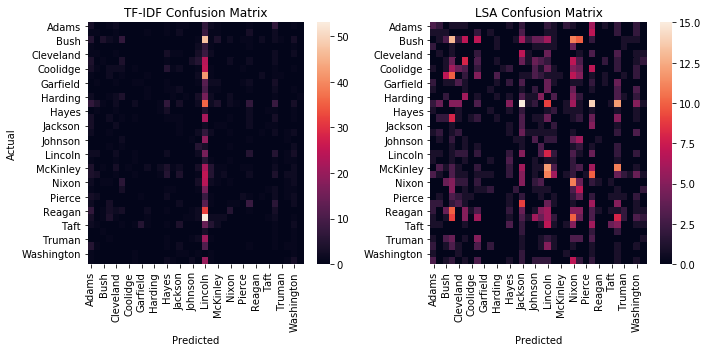

In [36]:
labels = sorted(Y_test.unique())
    
# Make tfidf confusion matrix, send to df
cm_tf = confusion_matrix(Y_test, Y_pred_tf)
df_cm_tf = pd.DataFrame(cm_tf, labels, labels)
  
# Make lsa confusion matrix, send to df
cm_lsa = confusion_matrix(Y_test, Y_pred_lsa)
df_cm_lsa = pd.DataFrame(cm_lsa, labels, labels)
    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        
#confusion matrix heatmaps 
sns.heatmap(df_cm_tf, ax=ax1)
sns.heatmap(df_cm_lsa, ax=ax2)

ax1.set_title('TF-IDF Confusion Matrix')
ax2.set_title('LSA Confusion Matrix')

ax1.set_ylabel('Actual')
    
ax1.set_xlabel('Predicted')
ax2.set_xlabel('Predicted')

plt.tight_layout()
plt.show()

In [37]:
feat_importance = rfc.fit(X_train1, Y_train).feature_importances_
features = vectorizer.get_feature_names()

importance_df = pd.DataFrame({'word': vectorizer.get_feature_names(), 'importance': feat_importance})
importance_df.sort_values(by='importance', ascending=False).head(10)

,word,importance
1579,function,0.019603
2210,measure,0.018289
1757,house,0.011988
1142,earlier,0.011719
92,adopt,0.010486
228,appreciation,0.009549
869,dare,0.009367
2459,party,0.009294
251,arising,0.009235
1199,eminence,0.009233


As we can see above, the random forest model worked slightly better on the LSA feature set. The model performed poorly for both.

## Logistic Regression

In [39]:
#Logistic Regression model to test TF-IDF features
lr = LogisticRegression()
 
X_train1 = X_train_tfidf
X_test1 = X_test_tfidf
    
lr.fit(X_train1, Y_train)
Y_pred_tf = lr.fit(X_train1, Y_train).predict(X_test1)
        
print('TF-IDF Features:')
print('Train accuracy:', lr.score(X_train1, Y_train))
print('Test accuracy:', lr.score(X_test1, Y_test))

TF-IDF Features:
Train accuracy: 0.6055875102711585
Test accuracy: 0.23089564502875926


In [40]:
#Logistic Regression model to test LSA features
lr = LogisticRegression()
 
X_train2 = X_train_lsa
X_test2 = X_test_lsa

lr.fit(X_train2, Y_train)
Y_pred_lsa = lr.fit(X_train2, Y_train).predict(X_test2)

print('LSA Features:')
print('Train accuracy:', lr.score(X_train2, Y_train))
print('Test accuracy:', lr.score(X_test2, Y_test))

LSA Features:
Train accuracy: 0.44042728019720623
Test accuracy: 0.23500410846343467


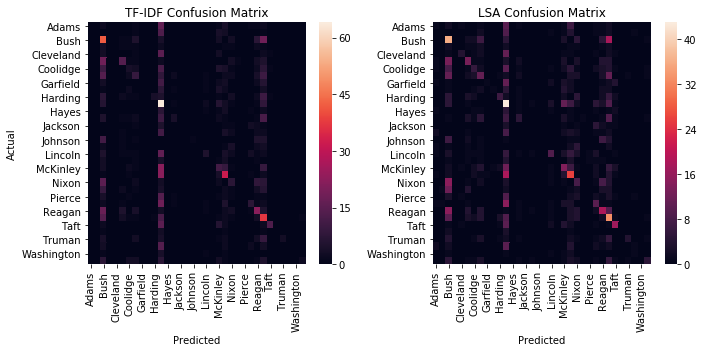

In [17]:
labels = sorted(Y_test.unique())
    
# Make tfidf confusion matrix, send to df
cm_tf = confusion_matrix(Y_test, Y_pred_tf)
df_cm_tf = pd.DataFrame(cm_tf, labels, labels)
  
# Make lsa confusion matrix, send to df
cm_lsa = confusion_matrix(Y_test, Y_pred_lsa)
df_cm_lsa = pd.DataFrame(cm_lsa, labels, labels)
    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        
#confusion matrix heatmaps 
sns.heatmap(df_cm_tf, ax=ax1)
sns.heatmap(df_cm_lsa, ax=ax2)

ax1.set_title('TF-IDF Confusion Matrix')
ax2.set_title('LSA Confusion Matrix')

ax1.set_ylabel('Actual')
    
ax1.set_xlabel('Predicted')
ax2.set_xlabel('Predicted')

plt.tight_layout()
plt.show()

The logistic regression model worked performed better than the random forest model for both feature sets. It worked best on the TF-IDF feature set.

## Conslusion

Cmparing the two models, we can see that the logistic regression model worked best on both sets of features. I could have done other things such as removing reapated words or breaking down the sentences into smaller peices in order to raise my accuracy scores. 

When I started this project, I did not fully undertand NLP and how to create a set of features from a corpus, especially using the unsupervised methods. However, after completing this assignment, I learned how to creat features using TF-IDF and LSA in order to reduce dimensionality and to identify key words. Even though the models I used could be improved upon, I know have a better understanding of NLP and text classification.